In [1]:
import matplotlib

In [2]:
matplotlib.use('Agg')

In [3]:
%matplotlib inline

In [4]:
import matplotlib.pyplot as plt

In [5]:
import bisect

In [6]:
import itertools

In [7]:
import numpy

In [8]:
import os

In [9]:
import pickle

---

# Extracting Genetic Interactions from BIOGRID

**2015 May 13-14**

Downloaded *BIOGRID-ORGANISM-3.3.124.tab2.zip.*

**2015 August 4**

Using *BIOGRID-ORGANISM-3.4.127.tab2*.

Header line looks like:

In [1]:
%%bash
head -1 /work/jyoung/DataDownload/BIOGRID/BIOGRID-ORGANISM-3.3.124.tab2/BIOGRID-ORGANISM-Drosophila_melanogaster-3.3.124.tab2.txt

#BioGRID Interaction ID	Entrez Gene Interactor A	Entrez Gene Interactor B	BioGRID ID Interactor A	BioGRID ID Interactor B	Systematic Name Interactor A	Systematic Name Interactor B	Official Symbol Interactor A	Official Symbol Interactor B	Synonyms Interactor A	Synonyms Interactor B	Experimental System	Experimental System Type	Author	Pubmed ID	Organism Interactor A	Organism Interactor B	Throughput	Score	Modification	Phenotypes	Qualifications	Tags	Source Database


Data lines look like:

In [2]:
%%bash
head -2 /work/jyoung/DataDownload/BIOGRID/BIOGRID-ORGANISM-3.3.124.tab2/BIOGRID-ORGANISM-Drosophila_melanogaster-3.3.124.tab2.txt | tail -1

30772	43383	37006	68259	62692	Dmel_CG10002	Dmel_CG6459	fkh	P32	CG10002|DmelCG10002|Dmfkh|Sebp2|dFoxA	CG 6459|CG6459|DmelCG6459|dp32	Two-hybrid	physical	Giot L (2003)	14605208	7227	7227	High Throughput	-	-	-	-	-	BIOGRID


Filter lines that have "Experimental System Type" as "genetic":

In [1]:
readPath = ("/work/jyoung/DataDownload/BIOGRID/BIOGRID-ORGANISM-3.4.127.tab2/"
            "BIOGRID-ORGANISM-Drosophila_melanogaster-3.4.127.tab2.txt")

In [7]:
writePath = '/work/jyoung/genetic_interact/data/BIOGRID-3.4.127-fly.txt'

In [8]:
colNum = open(readPath).readline().strip().split('\t').index('Experimental System Type')

In [9]:
with open(writePath, 'w') as fid:
    fid.writelines([line for line in open(readPath) if line.split('\t')[colNum] == 'genetic'])

In [10]:
%%bash
wc -l /work/jyoung/genetic_interact/data/BIOGRID-3.4.127-fly.txt

9978 /work/jyoung/genetic_interact/data/BIOGRID-3.4.127-fly.txt


## Breakdown of experimental evidence codes

**2015 June 10**

Using *BIOGRID-ORGANISM-3.3.124.tab2*.

**2015 August 4**

Using *BIOGRID-ORGANISM-3.4.127.tab2*. 

In [11]:
os.chdir('/work/jyoung/genetic_interact/data')

In [12]:
catg = dict()
genes = set()
for line in open('BIOGRID-3.4.127-fly.txt'):
    tokens = line.split('\t')
    genes.update(tokens[1:3])
    catg[tokens[11]] = catg.get(tokens[11], 0) + 1

In [13]:
len(genes)

1039

In [14]:
catg

{'Dosage Rescue': 9,
 'Negative Genetic': 1,
 'Phenotypic Enhancement': 4334,
 'Phenotypic Suppression': 5608,
 'Synthetic Growth Defect': 3,
 'Synthetic Haploinsufficiency': 2,
 'Synthetic Lethality': 2,
 'Synthetic Rescue': 19}

---

# FlyNet

**2015 May 13-15**

Downloaded [FlyNet](http://www.inetbio.org/flynet/downloadnetwork.php).

In [10]:
%%bash
head -5 /work/jyoung/DataDownload/FunctionalNet/FlyNet.txt

FBgn0000588	FBgn0000629	5.9845282658116
FBgn0004406	FBgn0004407	5.98385558064729
FBgn0039907	FBgn0043900	5.97562686691344
FBgn0000352	FBgn0001079	5.96739494043322
FBgn0000499	FBgn0002945	5.96444550034175


So FlyNet uses FlyBase IDs. These will be converted to Entrez IDs for use with the BIOGRID genetic interactions. Note that the FlyBase conversion tool doens't actually convert to Entrez IDs. DAVID seems to only recognize 12138 of the FlyBase IDs. BioMart only "advises" conversion of 500 IDs at a time. 

Using the R Bioconductor library *org.Dm.eg.db*, an R script *convert_flynet_entrez.R* was written to convert the FlyBase IDs in FlyNet to Entrez IDs. Not all IDs were able to be converted; the FlyBase IDs without a conversion are labeled NULL. The output file is *FlyNetEntrez.txt*. 

**2015 June 11**

Create a new file, *FlyNetEntrez-noNull.txt*, that has any line with NULL entries removed. 

In [5]:
%%bash
sed '/NULL/d' FlyNetEntrez.txt > FlyNetEntrez-noNull.txt

---

# Predictability of Each BIOGRID Interaction Type

**2015 June 11**

Using *BIOGRID-ORGANISM-3.3.124.tab2*.

**2015 August 4**

Using *BIOGRID-ORGANISM-3.4.127.tab2*. 

**2015 August 4-7**

Major updates to *func_net_pred.py*. It no longer requires working only with Entrez IDs. The *get_entrez_indices( )* function has been replaced with the *assign_gene_indices( )* function. Sorting of gene IDs still occurs so that every time the script is run, the indices of the adjacency matrix always correspond to the same gene IDs. The *write_seeds_text( )* function no longer does a gene ID conversion. The *main( )* function contains a flag variable that indicates whether or not any conversion needs to be done. Note that the conversion should be based from the functional network; that is, the conversion dictionary should be built from converting the genes in the network. 

The updated version of *func_net_pred.py* was tested to ensure that it produces the same plots and seed set text output as before.

In an ideal scenario, the functional network and the BIOGRID file use the same gene IDs. If not, then convert to Entrez, as it seems to have less ambiguity than either official symbols or systematic name. For example, the R conversion has names such as "CG6646 gene product from transcript CG6646-RA", while BIOGRID simply uses "CG6646". 

In [10]:
os.chdir('/work/jyoung/genetic_interact/src')

Number of genes in functional network: 13052
Number of genes in interactions: 14
Number of seed sets: 14


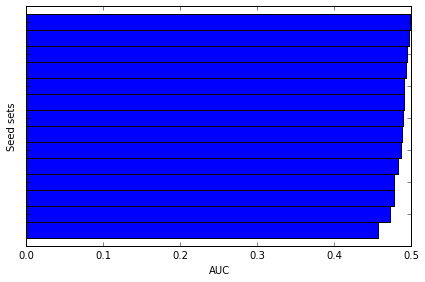

In [13]:
%run func_net_pred 'Dosage Rescue'

Number of genes in functional network: 13052
Number of genes in interactions: 3
Number of seed sets: 3


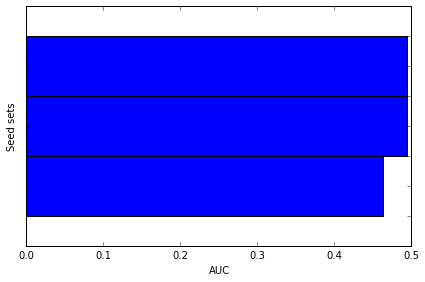

In [14]:
%run func_net_pred 'Synthetic Haploinsufficiency'

Number of genes in functional network: 13052
Number of genes in interactions: 755
Number of seed sets: 742


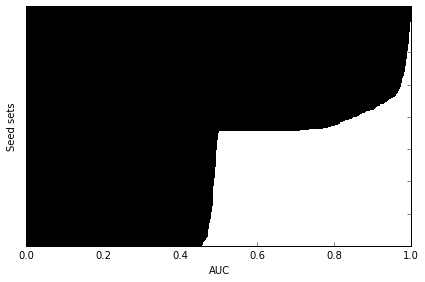

In [15]:
%run func_net_pred 'Phenotypic Enhancement'

Number of genes in functional network: 13052
Number of genes in interactions: 820
Number of seed sets: 808


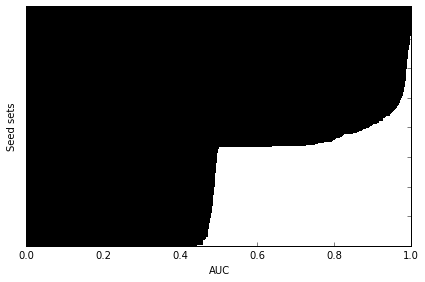

In [16]:
%run func_net_pred 'Phenotypic Suppression'

Number of genes in functional network: 13052
Number of genes in interactions: 2
Number of seed sets: 2


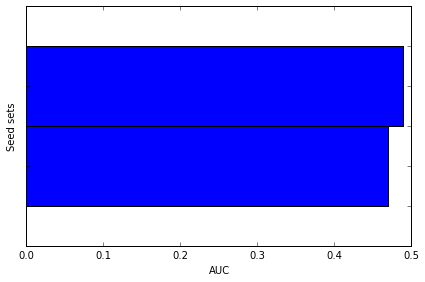

In [17]:
%run func_net_pred 'Negative Genetic'

Number of genes in functional network: 13052
Number of genes in interactions: 26
Number of seed sets: 26


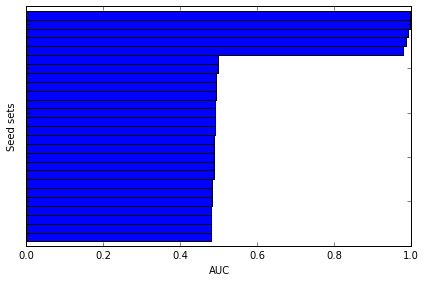

In [18]:
%run func_net_pred 'Synthetic Rescue'

Number of genes in functional network: 13052
Number of genes in interactions: 5
Number of seed sets: 5


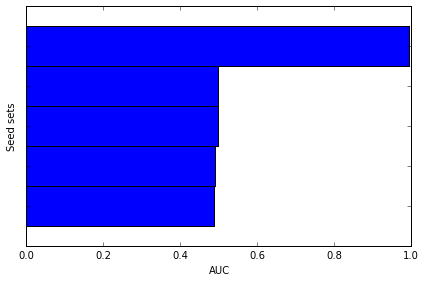

In [19]:
%run func_net_pred 'Synthetic Growth Defect'

Number of genes in functional network: 13052
Number of genes in interactions: 4
Number of seed sets: 4


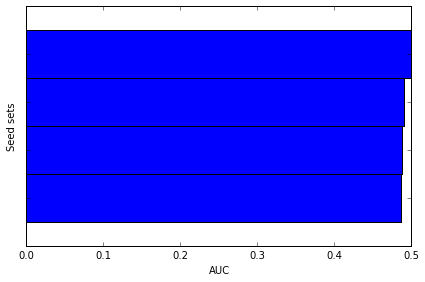

In [20]:
%run func_net_pred 'Synthetic Lethality'

---

# Output Gene Names in Predictable Seed Sets

**2015 July 2-3**

To examine the predictable seed sets (those having high AUC), write out the gene names of the seeds and their interactors. The fly Entrez IDs will need to be converted to fly gene names. Use the R Bioconductor library *org.Dm.eg.db* to output a conversion table to text, which can be read and stored in Python. 

    > library("org.Dm.eg.db")
    > entrezIDs <- ls(org.Dm.egGENENAME)
    > length(entrezIDs)
    [1] 24620
    > entrezIDs[1:5]
    [1] "30970" "30971" "30972" "30973" "30975"
    > head(toTable(org.Dm.egGENENAME[entrezIDs]))
      gene_id                                       gene_name
    1   30970   CG3038 gene product from transcript CG3038-RC
    2   30971   CG2995 gene product from transcript CG2995-RB
    3   30972 CG13377 gene product from transcript CG13377-RB
    4   30973                                        cinnamon
    5   30975                                      erect wing
    6   30976 CG13375 gene product from transcript CG13375-RB
    > conversTab <- toTable(org.Dm.egGENENAME[entrezIDs])
    > write.table(conversTab, file="/work/jyoung/DataProcessed/org.Dm.egGENENAME.txt",
                  quote=FALSE, sep="\t", row.names=FALSE)

Next, verify that the table has unique gene IDs and read this conversion table into a Python dictionary. 

In [2]:
%%bash
head -4 /work/jyoung/DataProcessed/org.Dm.egGENENAME.txt

gene_id	gene_name
30970	CG3038 gene product from transcript CG3038-RC
30971	CG2995 gene product from transcript CG2995-RB
30972	CG13377 gene product from transcript CG13377-RB


In [1]:
%%bash
cut -f1 /work/jyoung/DataProcessed/org.Dm.egGENENAME.txt | sort | uniq | wc -l

24621


In [4]:
entrez2name = dict()
fid = open('/work/jyoung/DataProcessed/org.Dm.egGENENAME.txt')
header = fid.readline()
for line in fid:
    tokens = line.strip().split('\t')
    entrez2name[tokens[0]] = tokens[1]
fid.close()

Now check whether all of the Entrez IDs in FlyNet are included in the conversion dictionary.

In [8]:
allNetEntrez = set()
for line in open('../data/FlyNetEntrez-noNull.txt'):
    allNetEntrez.update(line.split('\t')[:2])

In [9]:
len(allNetEntrez)

13052

In [10]:
len(allNetEntrez - set(entrez2name.keys()))

0

In [12]:
pickle.dump(entrez2name, open('/work/jyoung/PyPickle/flyentrez2names.p', 'wb'))

Modifications to the *write_seeds_text( )* function (which was originally from *pred_from_huNet_v2.py*):
- changed the number of seed sets written to be based on AUC score instead of an arbitrary numerical cutoff
- changed the filepath for Entrez-to-name conversion from */work/jyoung/PyPickle/entrez2names.p* to *flyentrez2names.p*
- *entrez2names* converts an Entrez ID to its multiple gene names, the 1st of which is commonly used. On the other hand, *flyentrez2names* converts a single Entrez ID to a single gene name. Therefore, any *entrez2names[ ][0]* code is changed to *entrez2names[ ]*.

Writing out seed sets for Phenotypic Enhancement (using v3.4.127 on 2015-08-04):

In [22]:
%run func_net_pred 'Phenotypic Enhancement'

Number of genes in functional network: 13052
Number of genes in interactions: 755
Number of seed sets: 742


In [23]:
%run func_net_pred 'Phenotypic Suppression'

Number of genes in functional network: 13052
Number of genes in interactions: 820
Number of seed sets: 808


In [24]:
%run func_net_pred 'Synthetic Rescue'

Number of genes in functional network: 13052
Number of genes in interactions: 26
Number of seed sets: 26


In [25]:
%run func_net_pred 'Synthetic Growth Defect'

Number of genes in functional network: 13052
Number of genes in interactions: 5
Number of seed sets: 5


---

# Cytoscape Network Visualization

**2015 July 6**

To visualize the predictive seed sets in Cytoscape, write out the interacting genes in SIF format. The plan is to use the ClueGO app, which accepts gene IDs. So the text file with the seed sets will not only need to be re-written in SIF format, but with Entrez IDs. 

In [6]:
os.chdir('/work/jyoung/genetic_interact/src')

In [7]:
import func_net_pred

In [8]:
experimentSys = 'Phenotypic Enhancement'

In [10]:
# copied from main()
node2edgewt = func_net_pred.process_func_net()
entrez2idx = func_net_pred.get_entrez_indices(node2edgewt)
adjMat = numpy.load('../data/FlyNet_adj_matrix.npy')
seedSets = func_net_pred.read_biogrid(experimentSys)
seedAUC, seed2interactors = func_net_pred.seed_set_predictability(entrez2idx, adjMat, seedSets)

Number of genes in interactions: 755


In [15]:
def write_sif(seed2interactors, seedAUC, writeFilename):
    """
    Adapted from write_seed_sets(). Writes seed sets into SIF format for input 
    into Cytoscape. 'gi' is genetic interaction for the <relationship type> 
    ARGUMENTS:
        1.) <dict> {seed Entrez in func net: {interactors' Entrez in func net}}
        2.) <list> [(seed AUC seed Entrez)]
        3.) <string> output filename
    """
    AUCcutoff = 0.9
    aucs = [v[0] for v in seedAUC]
    cutIndex = len(aucs) - bisect.bisect_left(aucs, AUCcutoff)
    writeFile = open(writeFilename, 'w')
    for i in range(1, cutIndex+1):
        intactEntrez = list(seed2interactors[seedAUC[-i][1]])
        if len(intactEntrez) > 1:
            writeFile.write(seedAUC[-i][1] + '\tgi\t' + '\t'.join(intactEntrez) + '\n')
    writeFile.close()

In [12]:
os.chdir('/work/jyoung/genetic_interact/results')

In [16]:
write_sif(seed2interactors, seedAUC, 'PhenotypicEnhancement_seed_entrez.sif')